In [8]:
import torch
import torch.nn as nn

In [9]:
class Self_Attention(nn.Module):
  def __init__(self, embed_size, heads): # heads - how many parts we devide the matrix into,  # embe_size - no. of embeddings i.e 256 or 512
    super(Self_Attention, self).__init__()
    self.embed_size = embed_size
    self.heads = heads
    self.head_dim = embed_size // heads

    assert(self.head_dim * heads == embed_size)
    self.values = nn.Linear(self.head_dim, self.head_dim, bias = False)
    self.keys = nn.Linear(self.head_dim, self.head_dim, bias = False)
    self.queries = nn.Linear(self.head_dim, self.head_dim, bias = False)
    self.fc_out = nn.Linear(heads*self.head_dim, embed_size)

  def forward(self, query, keys, values, mask):
    N = query.shape[0]
    value_len, key_len, query_len = values.shape[1], keys.shape[1], query.shape[1]

    # splitting the embedding into self.heads pieces
    values = values.reshape(N, value_len, self.heads, self.head_dim)
    keys = keys.reshape(N, key_len, self.heads, self.head_dim)
    queries = queries.reshape(N, query_len, self.heads, self.head_dim)

    energy = torch.einsum("nqhd, nkhd->nhqk", [queries, keys])
    # queries shape = (N, query_len, self.heads, self.head_dim)
    # keys shape = (N, key_len, self.heads, self.head_dim)
    # energy shape = (N, heads, query_len, key_len)  i.e 6 x 512

    if mask is not None:
      energy = energy.masked_fill(mask == 0, float("-1e20"))

    attention = torch.softmax(energy / (self.embed_size**(1/2)), dim = 3)
    out = torch.einsum("nhql, nlhd->nqgd", [attention, values]).reshape(N, query_len, self.heads*self.head_dim)
    # attention shape = (N, heads, query_len, key_len)
    # values shape = (N, values_len, heads, heads_dim)
    # out shape = (N, query_len, head, head_dim)

    out = self.fc_out(out)
    return out

## **Some Important Points**

## 1. `torch.einsum()`
- It is a powerful function in PyTorch that provides a way to perform tensor operations using Einstein summation notation.
- This notation is a compact and flexible way to express operations on tensors, such as dot products, matrix multiplications, and reductions.

## 2. Einstein Summation Notation
Einstein summation notation is a way to specify tensor operations in a concise manner. The notation uses indices to represent dimensions of tensors and summation over repeated indices.

Components of Notation
- Index Notation: Each dimension of the tensors is represented by a letter (e.g., i, j, k).
- Summation: Repeated indices in the equation imply summation over those indices.
- Free Indices: Indices that appear only once in the equation specify the dimensions of the output tensor.

## 3. Calculations
* The matrix size of query and keys is (sequence x embed_size) where:
  *   Sequence =  No of words (lenght of words)
  *   Embed_size = Size of the embedding

* The size of dot product of query and key matrix will be (sequence x sequence). The values are stored in "energy" tensor.

* `energy.masked_fill()` is a PyTorch function that replaces all elements in energy where the condition mask == 0 is true with a specified value, in this case, float("-1e20").

* In the attention tesnor, the dot product of query and key is stored with dividing embed_size**1/2 (i.e under root of 512)

* **out tensor** stores the dot product of attention with values matrix, now the size of attention tensor is (sequence x sequence) and the size of values matrix is (sequence x embed_size), therefore the resulting out tensor will be of shape (sequence x embed_size)

* **heads * head_dim** is the combined dimension of all attention heads.

* The output from multiple attention heads is concatenated into a single tensor, but we need to ensure the output has the correct dimension for the next layer in the Transformer. The fully connected layer does this by applying a linear transformation to each element in the sequence, reducing the combined dimension **(heads * head_dim)** back to the original embedding size.

* **return out:**

  * This line simply returns the final output of the multi-head attention mechanism.
  * The **returned out** tensor will have the shape (N, query_len, embed_size), which can be passed to the next layer in the Transformer, such as a feedforward neural network or another layer of attention.


In [10]:
class Transformer(nn.Module):
  def __init__(self, embed_size, heads, dropout, forward_expansion):
    super(Transformer, self).__init__()
    self.attention = Self_Attention(embed_size, heads)
    self.norm1 = nn.LayerNorm(embed_size)
    self.norm2 = nn.LayerNorm(embed_size)

    self.feed_forward = nn.Sequential(
        nn.Linear(embed_size, forward_expansion*embed_size),
        nn.ReLU(),
        nn.Linear(forward_expansion*embed_size, embed_size)
    )
    self.dropout = nn.Dropout(dropout)

  def forward(self, value, key, query, mask):
    attention = self.attention(value, key, query, mask)

    x = self.dropout(self.norm1(attention + query))
    forward = self.feed_forward(x)
    out = self.dropout(self.norm2(forward + x))
    return out

## **Transformer Block**

* Firstly, the two normalization layers are created.

* As shown in the figure, a feed forward layer is created and it is typically a fully connected layer or a sequence of layers with non-linear activations.

* Then dropout is called which in terms randomly sets some values to 0 to prevent overfitting


## **Forward Pass**

* `attention` + `query` adds the original `query` to the output of the attention mechanism. This is known as a residual or skip connection, which helps in training deep networks by allowing gradients to flow more easily.

* `self.norm1(...)` applies layer normalization to the result, which helps stabilize and speed up training by normalizing the inputs across the feature dimensions.

* `self.dropout(...)` then applies dropout to the normalized output, randomly setting some of the values to zero to prevent overfitting.

* This line passes the output x through a feedforward neural network, which is typically a fully connected layer or a sequence of layers with non-linear activations.

* In the context of Transformers, this feedforward network usually consists of two linear transformations with a non-linearity in between (often ReLU).







<img src="https://drive.google.com/file/d/1LtOt-CAH1rl0UF9h_8rLsFzzYnvP9Zy8/view?usp=drive_link">

In [11]:
class Encoder(nn.Module):
  def __init__(
      self,
      src_vocab_size,
      embed_size,
      num_layers,
      heads,
      device,
      forward_expansion,
      dropout,
      max_length,):

    super(Encoder, self).__init__()
    self.embed_size = embed_size
    self.device = device
    self.word_embedding = nn.Embedding(src_vocab_size, embed_size)
    self.position_embedding = nn.Embedding(max_length, embed_size)

    self.layers = nn.ModuleList(
        [
            Transformer(
                embed_size,
                heads,
                dropout = dropout,
                forward_expansion = forward_expansion,
            )
        ]
    )

  def forward(self, x, mask):
    N, seq_length = x.shape
    positions = torch.arange(0, seq_length).expand(N, seq_length).to(self.device)

    out = self.dropout(self.word_embedding(x) + self.position_embedding(positions))
    for layers in self.layers:
      out = layers(out, out, out, mask)

    return out

## **Encoder**

* `nn.Embedding(src_vocab_size, embed_size)` is a PyTorch layer that maps each token (e.g., a word or subword) in the input vocabulary to a continuous vector representation.

* `src_vocab_size`: This is the size of the source vocabulary, meaning the total number of unique tokens (words, subwords, etc.) that the model can recognize. Each token in the vocabulary is assigned a unique integer index.

* `embed_size`: This is the size of the embedding vector. Each token in the vocabulary will be represented as a vector of this length. For example, if embed_size is 512, each token will be mapped to a 512-dimensional vector.

* The purpose of this embedding layer is to convert the discrete tokens (which are just indices) into dense vectors that can capture semantic meaning and be used as inputs to the neural network.
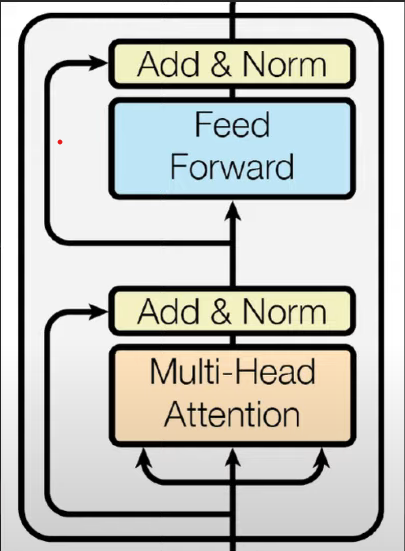

In [12]:
class DecoderBlock(nn.Module):
  def __init__(self, embed_size, heads, forward_expansion, dropout, device):
    super(DecoderBlock, self).__init__()
    self.attention = Self_Attention(embed_size, heads)
    self.norm = nn.LayerNorm(embed_size)
    self.Transformer = Transformer(embed_size, heads, dropout, forward_expansion)
    self.dropout = nn.Dropout(dropout)

  def forward(self, x, value, key, src_mask, target_mask):
    attention = self.attention(x)
    query = self.dropout(self.norm(attention + x))
    out = self.Transformer(value, key, query, src_mask)
    return out

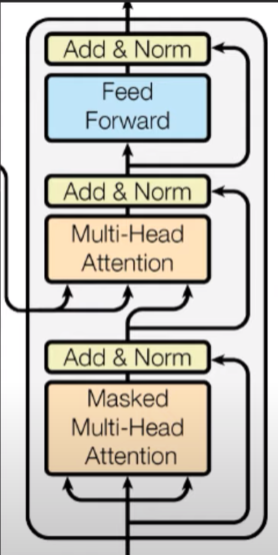

In [13]:
class Decoder(nn.Module):
  def __init__(
      self,
      trg_vocab_size,
      embed_size,
      num_layers,
      heads,
      forward_expansion,
      dropout,
      device,
      max_length,):
    super(Decoder, self).__init__()
    self.device = device
    self.word_embedding = nn.Embedding(trg_vocab_size, embed_size)
    self.position_embedding = nn.Embedding(max_length, embed_size)

    self.layers = nn.ModuleList(
        [DecoderBlock(embed_size, heads, forward_expansion, dropout, device)
        for _ in range(num_layers)]
    )

    self.fc_out = nn.Linear(embed_size, trg_vocab_size)
    self.dropout = nn.Dropout(dropout)

  def forward(self, x, enc_out, src_mask, target_mask):
    N, seq_length = x.shape
    positions = torch.arange(0, seq_length).expand(N, seq_length).to(self.device)
    x = self.dropout(self.word_embedding(x) + self.position_embedding(positions))

    for layer in self.layers:
      x = layer(x, enc_out, enc_out, src_mask, target_mask)

    out = self.fc_out(x)

In [14]:
class MainTransformer(nn.Module):
  def __init__(
      self,
      src_vocab_size,
      trg_vocab_size,
      src_pad_idx,
      trg_pad_idx,
      embed_size = 256,
      num_layers = 6,
      forward_expansion = 4,
      heads = 8,
      dropout = 0,
      device = "cuda",
      max_length = 100,):
    super(MainTransformer, self).__init__()

    self.encoder = Encoder(
        src_vocab_size,
        embed_size,
        num_layers,
        heads,
        device,
        forward_expansion,
        dropout,
        max_length
    )

    self.decoder = Decoder(
        trg_vocab_size,
        embed_size,
        num_layers,
        heads,
        device,
        forward_expansion,
        dropout,
        max_length
    )

    self.src_pad_idx = src_pad_idx
    self.trg_pad_idx = trg_pad_idx
    self.device = device

  def make_src_mask(self, src):
    src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)
    return src_mask.to(self.device)

  def make_trg_mask(self, trg):
    N,trg_len = trg.shape
    trg_mask = torch.tril(torch.ones((trg_len, trg_len))).expand(
        N, 1, trg_len, trg_len
    )

    return trg_mask.to(self.device)

  def forward(self, src, trg):
    src_mask = self.make_src_mask(src)
    trg_mask = self.make_trg_mask(trg)
    enc_src = self.encoder(src, src_mask)
    out = self.decoder(trg, enc_src, src_mask, trg_mask)
    return out